In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from Potato import plotparams
import pandas as pd
import os
import scipy
import numpy as np
import math
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy.time import Time
from astropy.timeseries import LombScargle as ls
import heapq
from IPython.display import display, Math

In [2]:
#Defining the read_lightcurve function. This function reads data files and imports them
def read_lightcurve_dat(asas_sn_id, guide = 'known_dipper_lightcurves/'):
    """
    Input: 
        asas_sn_id: the asassn id of the desired star
        guide: the path to the data file of the desired star

    Output: 
        dfv: This is the dataframe for the V-band data of the star
        dfg: This is the dataframe for the g-band data of the star
    
    This function reads the data of the desired star by going to the corresponding file and copying the data of that file onto 
    a data frame. This data frame is then sorted into two data frames by comparing the value in the Photo filter column. If the
    Photo filter column data has a value of one, its row is sorted into the data frame corresponding to the V-band. If the Photo
    filter column data has a value of zero, it gets sorted into the data frame corresponding to the g-band.
    """
    fname = os.path.join(guide, str(asas_sn_id)+'.dat')

    dfv = pd.DataFrame()
    dfg = pd.DataFrame()

    fdata = pd.read_fwf(fname, header=None)
    fdata.columns = ["JD", "Mag", "Mag_err", "Quality", "Cam_number", "Phot_filter", "Camera"] #These are the columns of data

    dfv = fdata.loc[fdata["Phot_filter"] == 1].reset_index(drop=True) #This sorts the data into the V-band
    dfg = fdata.loc[fdata["Phot_filter"] == 0].reset_index(drop=True) #This sorts the data into the g-band

    dfv['Mag'].astype(float)
    dfg['Mag'].astype(float)

    dfv['JD'].astype(float)
    dfg['JD'].astype(float)

    return dfv, dfg
#End of read_lightcurve function

In [3]:
def read_lightcurve_csv(asas_sn_id, guide = 'known_dipper_lightcurves/'):
    """
    Input: 
        asas_sn_id: the asassn id of the desired star
        guide: the path to the data file of the desired star

    Output: 
        dfv: This is the dataframe for the V-band data of the star
        dfg: This is the dataframe for the g-band data of the star
    
    This function reads the data of the desired star by going to the corresponding file and copying the data of that file onto 
    a data frame. This data frame is then sorted into two data frames by comparing the value in the Photo filter column. If the
    Photo filter column data has a value of one, its row is sorted into the data frame corresponding to the V-band. If the Photo
    filter column data has a value of zero, it gets sorted into the data frame corresponding to the g-band.
    """
    fname = os.path.join(guide, str(asas_sn_id)+'.csv')

    df = pd.read_csv(fname)

    df['Mag'] = pd.to_numeric(df['mag'],errors='coerce')
    df = df.dropna()
    
    df['Mag'].astype(float)
    df['JD'] = df.HJD.astype(float)

    dfg = df.loc[df['Filter'] == 'g'].reset_index(drop=True)
    dfv = df.loc[df['Filter'] == 'V'].reset_index(drop=True)

    return dfv, dfg

def year_to_jd(year):
    jd_epoch = 2449718.5 - (2.458 * 10 **6)
    year_epoch = 1995
    days_in_year = 365.25
    return (year-year_epoch)*days_in_year + jd_epoch-2450000

def jd_to_year(jd):
    jd_epoch = 2449718.5 - (2.458 * 10 **6)
    year_epoch = 1995
    days_in_year = 365.25
    return year_epoch + (jd - jd_epoch) / days_in_year

In [4]:
def jd_to_year(jd_minus_offset):
    jd = jd_minus_offset + 2458000
    return Time(jd, format='jd').decimalyear

In [5]:
def year_to_jd(year):
    return Time(year, format='decimalyear').jd - 2458000

In [6]:
def custom_id(ra,dec):
    c = SkyCoord(ra=ra_val*u.degree, dec=dec_val*u.degree, frame='icrs')
    ra_num = c.ra.hms
    dec_num = c.dec.dms

    if int(dec_num[0]) < 0:
        cust_id = 'J'+str(int(c.ra.hms[0])).rjust(2,'0')+str(int(c.ra.hms[1])).rjust(2,'0')+str(int(round(c.ra.hms[2]))).rjust(2,'0')+'$-$'+str(int(c.dec.dms[0])*(-1)).rjust(2,'0')+str(int(c.dec.dms[1])*(-1)).rjust(2,'0')+str(int(round(c.dec.dms[2])*(-1))).rjust(2,'0')
    else:
        cust_id = 'J'+str(int(c.ra.hms[0])).rjust(2,'0')+str(int(c.ra.hms[1])).rjust(2,'0')+str(int(round(c.ra.hms[2]))).rjust(2,'0')+'$+$'+str(int(c.dec.dms[0])).rjust(2,'0')+str(int(c.dec.dms[1])).rjust(2,'0')+str(int(round(c.dec.dms[2]))).rjust(2,'0')

    return cust_id

In [7]:
colors = ["#6b8bcd", "#b3b540", "#8f62ca", "#5eb550", "#c75d9c", "#4bb092", "#c5562f", "#6c7f39", 
              "#ce5761", "#c68c45", '#b5b246', '#d77fcc', '#7362cf', '#ce443f', '#3fc1bf', '#cda735',
              '#a1b055']

In [8]:
# J073234-200049
asassn_id = 335007754417
ra_val = 113.142375
dec_val = -20.01358333

J0720_id = custom_id(ra_val,dec_val)

J0720v, J0720g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0720 = np.mean(J0720g['Mag'])

J0720_mag_avg = [i - mean0720 for i in J0720g['Mag']]

peaks_J0720 = scipy.signal.find_peaks(J0720_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0720 = peaks_J0720[0]

peak_J0720 = [int(i) for i in peak_J0720]

peak_J0720 = pd.Series(peak_J0720)

In [9]:
# J175602+013135
asassn_id = 231929175915
ra_val = 269.0079973
dec_val = 1.52628966

J1701_id = custom_id(ra_val,dec_val)

J1701v, J1701g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1701 = np.mean(J1701g['Mag'])

J1701_mag_avg = [i - mean1701 for i in J1701g['Mag']]

peaks_J1701 = scipy.signal.find_peaks(J1701_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1701 = peaks_J1701[0]

peak_J1701 = [int(i) for i in peak_J1701]

peak_J1701 = pd.Series(peak_J1701)

In [10]:
# J223332+565552			
asassn_id = 60130040391
ra_val = 338.384125
dec_val = 56.93108333

J225655_id = custom_id(ra_val,dec_val)

J225655v, J225655g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean225655 = np.mean(J225655g['Mag'])

J225655_mag_avg = [i - mean225655 for i in J225655g['Mag']]

peaks_J225655 = scipy.signal.find_peaks(J225655_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J225655 = peaks_J225655[0]

peak_J225655 = [int(i) for i in peak_J225655]

peak_J225655 = pd.Series(peak_J225655)

In [11]:
# J062510-075341						
asassn_id = 377958261591
ra_val = 96.29314956
dec_val = -7.89464499

J0607_id = custom_id(ra_val,dec_val)

J0607v, J0607g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0607 = np.mean(J0607g['Mag'])

J0607_mag_avg = [i - mean0607 for i in J0607g['Mag']]

peaks_J0607 = scipy.signal.find_peaks(J0607_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0607 = peaks_J0607[0]

peak_J0607 = [int(i) for i in peak_J0607]

peak_J0607 = pd.Series(peak_J0607)

In [12]:
# J073924-272916									
asassn_id = 438086977939
ra_val = 114.8503576
dec_val = -27.48776143

J0727_id = custom_id(ra_val,dec_val)

J0727v, J0727g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0727 = np.mean(J0727g['Mag'])

J0727_mag_avg = [i - mean0727 for i in J0727g['Mag']]

peaks_J0727 = scipy.signal.find_peaks(J0727_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0727 = peaks_J0727[0]

peak_J0727 = [int(i) for i in peak_J0727]

peak_J0727 = pd.Series(peak_J0727)

In [13]:
# J074007-161608												
asassn_id = 360777377116
ra_val = 115.0276126
dec_val = -16.26896725

J0716_id = custom_id(ra_val,dec_val)

J0716v, J0716g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0716 = np.mean(J0716g['Mag'])

J0716_mag_avg = [i - mean0716 for i in J0716g['Mag']]

peaks_J0716 = scipy.signal.find_peaks(J0716_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0716 = peaks_J0716[0]

peak_J0716 = [int(i) for i in peak_J0716]

peak_J0716 = pd.Series(peak_J0716)

In [14]:
# J094848-545959															
asassn_id = 635655234580
ra_val = 147.1987289
dec_val = -54.99963893

J0954_id = custom_id(ra_val,dec_val)

J0954v, J0954g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0954 = np.mean(J0954g['Mag'])

J0954_mag_avg = [i - mean0954 for i in J0954g['Mag']]

peaks_J0954 = scipy.signal.find_peaks(J0954_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0954 = peaks_J0954[0]

peak_J0954 = [int(i) for i in peak_J0954]

peak_J0954 = pd.Series(peak_J0954)

In [15]:
# J162209-444247																		
asassn_id = 412317159120
ra_val = 245.5357562
dec_val = -44.71308061

J1644_id = custom_id(ra_val,dec_val)

J1644v, J1644g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1644 = np.mean(J1644g['Mag'])

J1644_mag_avg = [i - mean1644 for i in J1644g['Mag']]

peaks_J1644 = scipy.signal.find_peaks(J1644_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1644 = peaks_J1644[0]

peak_J1644 = [int(i) for i in peak_J1644]

peak_J1644 = pd.Series(peak_J1644)

In [16]:
# J183210-173432																					
asassn_id = 317827964025
ra_val = 278.0424857
dec_val = -17.57545433

J1817_id = custom_id(ra_val,dec_val)

J1817v, J1817g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1817 = np.mean(J1817g['Mag'])

J1817_mag_avg = [i - mean1817 for i in J1817g['Mag']]

peaks_J1817 = scipy.signal.find_peaks(J1817_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1817 = peaks_J1817[0]

peak_J1817 = [int(i) for i in peak_J1817]

peak_J1817 = pd.Series(peak_J1817)

In [17]:
# J183606-314826																					
asassn_id = 438086901547
ra_val = 279.0252466
dec_val = -31.80714478

J1831_id = custom_id(ra_val,dec_val)

J1831v, J1831g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

J1831g = J1831g.loc[J1831g.Mag < 15].reset_index(drop=True)

mean1831 = np.mean(J1831g['Mag'])

J1831_mag_avg = [i - mean1831 for i in J1831g['Mag']]

peaks_J1831 = scipy.signal.find_peaks(J1831_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1831 = peaks_J1831[0]

peak_J1831 = [int(i) for i in peak_J1831]

peak_J1831 = pd.Series(peak_J1831)

In [18]:
# J190316-195739																								
asassn_id = 515396514761
ra_val = 285.8184954
dec_val = -19.9609327

J1919_id = custom_id(ra_val,dec_val)

J1919v, J1919g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1919 = np.mean(J1919g['Mag'])

J1919_mag_avg = [i - mean1919 for i in J1919g['Mag']]

peaks_J1919 = scipy.signal.find_peaks(J1919_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1919 = peaks_J1919[0]

peak_J1919 = [int(i) for i in peak_J1919]

peak_J1919 = pd.Series(peak_J1919)

In [19]:
# J205245-713514																											
asassn_id = 463856535113
ra_val = 313.1890422
dec_val = -71.58708665

J2071_id = custom_id(ra_val,dec_val)

J2071v, J2071g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean2071 = np.mean(J2071g['Mag'])

J2071_mag_avg = [i - mean2071 for i in J2071g['Mag']]

peaks_J2071 = scipy.signal.find_peaks(J2071_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J2071 = peaks_J2071[0]

peak_J2071 = [int(i) for i in peak_J2071]

peak_J2071 = pd.Series(peak_J2071)

In [20]:
# J212132+480140																														
asassn_id = 120259184943
ra_val = 320.3840472
dec_val = 48.02785275

J2148_id = custom_id(ra_val,dec_val)

J2148v, J2148g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean2148 = np.mean(J2148g['Mag'])

J2148_mag_avg = [i - mean2148 for i in J2148g['Mag']]

peaks_J2148 = scipy.signal.find_peaks(J2148_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J2148 = peaks_J2148[0]

peak_J2148 = [int(i) for i in peak_J2148]

peak_J2148 = pd.Series(peak_J2148)

In [21]:
# J225702+562312																													
asassn_id = 25770019815
ra_val = 344.2585271
dec_val = 56.38663345	

J225623_id = custom_id(ra_val,dec_val)

J225623v, J225623g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean225623 = np.mean(J225623g['Mag'])

J225623_mag_avg = [i - mean225623 for i in J225623g['Mag']]

peaks_J225623 = scipy.signal.find_peaks(J225623_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J225623 = peaks_J225623[0]

peak_J225623 = [int(i) for i in peak_J225623]

peak_J225623 = pd.Series(peak_J225623)

Text(0.08, 0.5, 'g [mag]')

/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 2 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


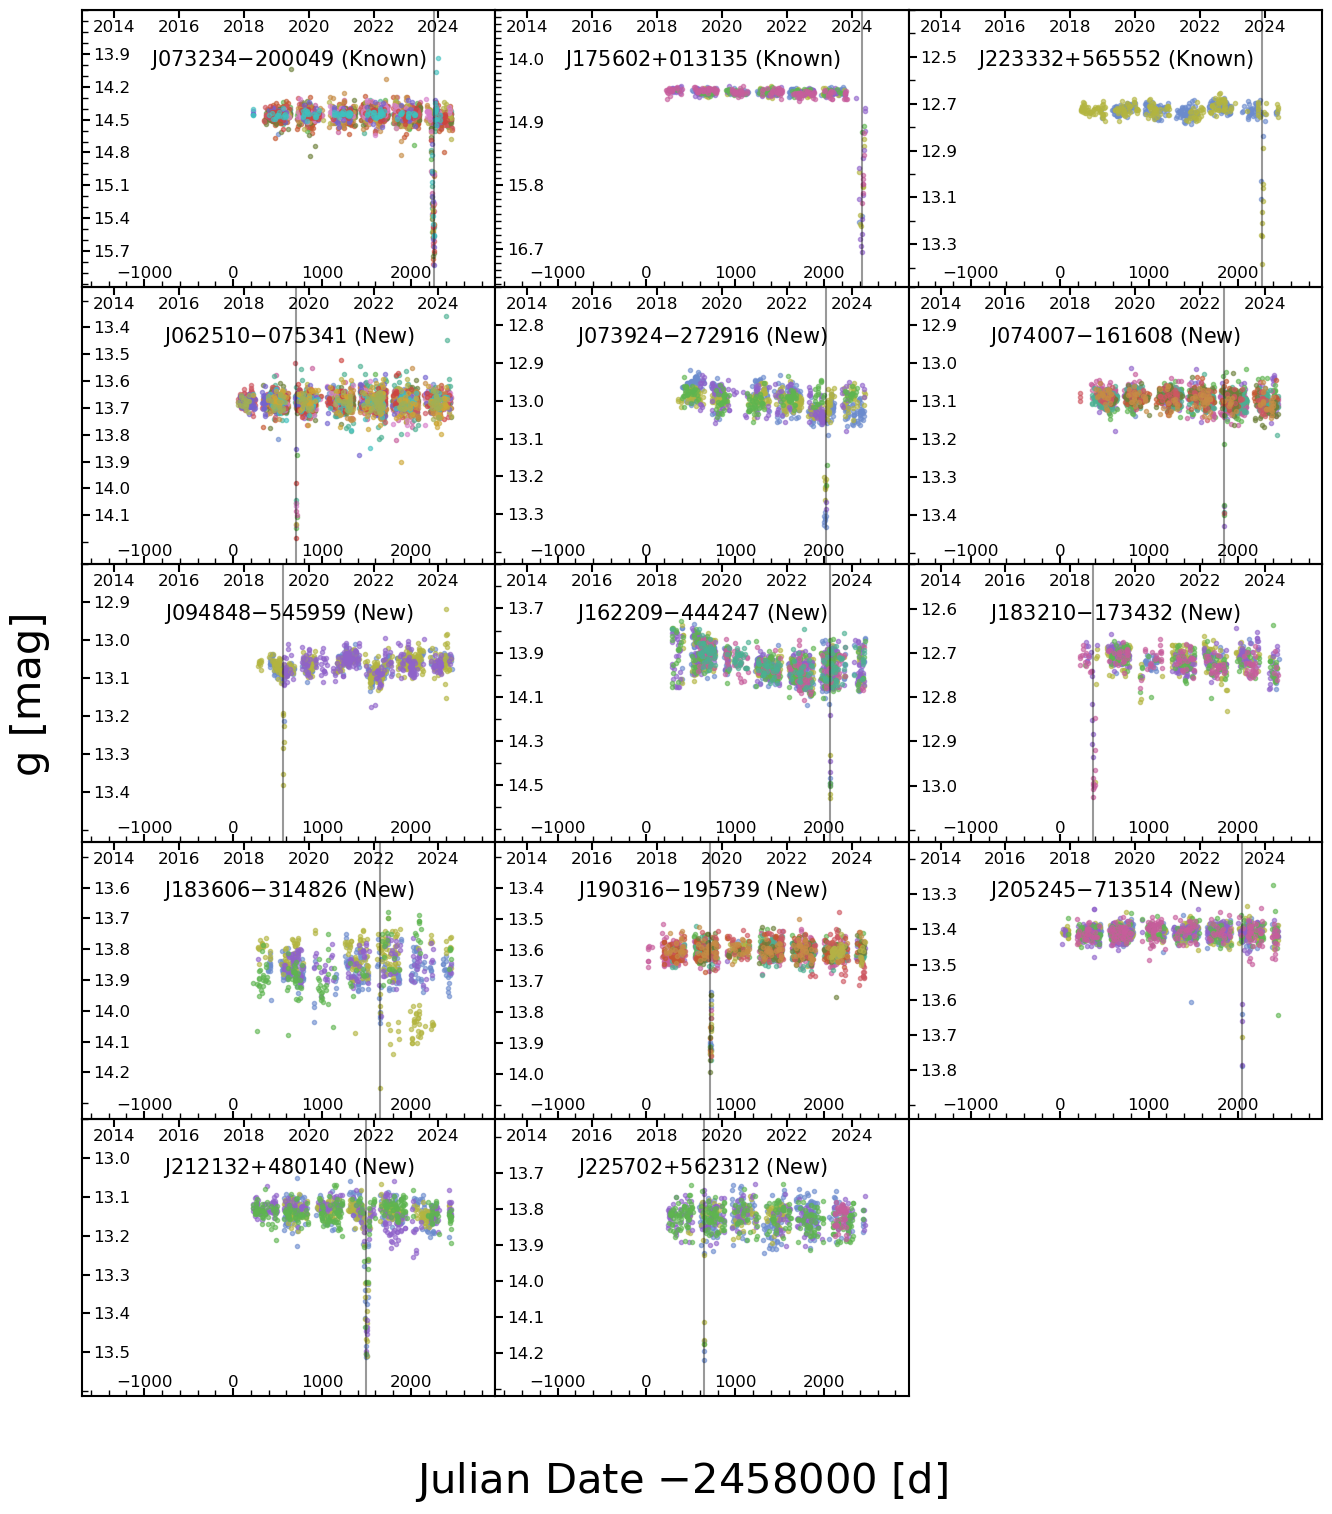

In [22]:
fig = plt.figure(figsize=(16,18))
gs = fig.add_gridspec(5,3,hspace=0,wspace=0)
ax = gs.subplots(sharex=True,sharey=False)

padnum = -40

titlesize = 15

# Subfig 1 (335007754417) (J073234-200049)
cams = J0720g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0720 = J0720g.loc[J0720g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0720["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0720["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0720)-2):
    ax[0,0].vlines((J0720g.JD[peak_J0720[i+2]] - (2.458 * 10**6)), 13.5, (max(J0720g['Mag'])+0.2), "k", alpha=0.4)

ax[0,0].set_title(J0720_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,0].set_xlim(-1700,2950)
ax[0,0].set_ylim(13.5,(max(J0720g['Mag'])+0.2))
ax[0,0].set_yticks(np.linspace(13.9, 15.7, 7))

# Subfig 2 (231929175915) (J175602+013135)
cams = J1701g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1701 = J1701g.loc[J1701g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1701["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1701["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1701)):
    ax[0,1].vlines((J1701g.JD[peak_J1701[i]] - (2.458 * 10**6)), 13.3, (max(J1701g['Mag'])+0.5), "k", alpha=0.4)

ax[0,1].set_title(J1701_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,1].set_ylim(13.3,(max(J1701g['Mag'])+0.5))
ax[0,1].set_yticks(np.linspace(14, 16.7, 4))

# Subfig 3 (60130040391) (J223332+565552)
J225655g = J225655g.loc[J225655g['Mag'] < 13.8].reset_index(drop=True)

cams = J225655g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225655 = J225655g.loc[J225655g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225655["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225655["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J225655)-1):
    ax[0,2].vlines((J225655g.JD[peak_J225655[i+1]] - (2.458 * 10**6)), 12.3, (max(J225655g['Mag'])+0.1), "k", alpha=0.4)

ax[0,2].set_title(J225655_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,2].set_ylim(12.3,(max(J225655g['Mag'])+0.1))
ax[0,2].set_yticks(np.linspace(12.5, 13.3, 5))

# Subfig 4 (J062510-075341)	(377958261591)
cams = J0607g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0607 = J0607g.loc[J0607g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0607["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0607["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0607)):
    ax[1,0].vlines((J0607g.JD[peak_J0607[i]] - (2.458 * 10**6)), 13.25, (max(J0607g['Mag'])+0.1), "k", alpha=0.4)

ax[1,0].set_title(J0607_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,0].set_ylim(13.25,(max(J0607g['Mag'])+0.1))
ax[1,0].set_yticks(np.linspace(13.4, 14.1, 8))

# Subfig 5 (J073924-272916)	(438086977939)
cams = J0727g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0727 = J0727g.loc[J0727g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0727["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0727["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0727)):
    ax[1,1].vlines((J0727g.JD[peak_J0727[i]] - (2.458 * 10**6)), 12.7, (max(J0727g['Mag'])+0.1), "k", alpha=0.4)

ax[1,1].set_title(J0727_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,1].set_ylim(12.7,(max(J0727g['Mag'])+0.1))
ax[1,1].set_yticks(np.linspace(12.8, 13.3, 6))

# Subfig 6 (J074007-161608)	(360777377116)
J0716g = J0716g.loc[J0716g['Mag'] < 13.75].reset_index(drop=True)

cams = J0716g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0716 = J0716g.loc[J0716g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0716["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0716["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0716)-1):
    ax[1,2].vlines((J0716g.JD[peak_J0716[i]] - (2.458 * 10**6)), 12.8, (max(J0716g['Mag'])+0.1), "k", alpha=0.4)

ax[1,2].set_title(J0716_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,2].set_ylim(12.8,(max(J0716g['Mag'])+0.1))
ax[1,2].set_yticks(np.linspace(12.9, 13.4, 6))

# Subfig 7 (J094848-545959)	(635655234580)
cams = J0954g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0954 = J0954g.loc[J0954g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0954["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0954["Mag"].astype(float)
    ax[2,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0954)):
    ax[2,0].vlines((J0954g.JD[peak_J0954[i]] - (2.458 * 10**6)), 12.8, (max(J0954g['Mag'])+0.15), "k", alpha=0.4)

ax[2,0].set_title(J0954_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,0].set_ylim(12.8,(max(J0954g['Mag'])+0.15))
ax[2,0].set_yticks(np.linspace(12.9, 13.4, 6))

# Subfig 8 (J162209-444247)	(412317159120)
cams = J1644g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1644 = J1644g.loc[J1644g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1644["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1644["Mag"].astype(float)
    ax[2,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1644)):
    ax[2,1].vlines((J1644g.JD[peak_J1644[i]] - (2.458 * 10**6)), 13.5, (max(J1644g['Mag'])+0.2), "k", alpha=0.4)

ax[2,1].set_title(J1644_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,1].set_ylim(13.5,(max(J1644g['Mag'])+0.2))
ax[2,1].set_yticks(np.linspace(13.7, 14.5, 5))

# Subfig 9 (J183210-173432)	(317827964025)
cams = J1817g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1817 = J1817g.loc[J1817g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1817["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1817["Mag"].astype(float)
    ax[2,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1817)):
    ax[2,2].vlines((J1817g.JD[peak_J1817[i]] - (2.458 * 10**6)), 12.5, (max(J1817g['Mag'])+0.1), "k", alpha=0.4)

ax[2,2].set_title(J1817_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,2].set_ylim(12.5,(max(J1817g['Mag'])+0.1))
ax[2,2].set_yticks(np.linspace(12.6, 13, 5))

# Subfig 10 (J183606-314826)	(438086901547)
J1831g = J1831g.loc[J1831g['Mag'] < 14.5].reset_index(drop=True)

cams = J1831g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1831 = J1831g.loc[J1831g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1831["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1831["Mag"].astype(float)
    ax[3,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1831)):
    ax[3,0].vlines((J1831g.JD[peak_J1831[i]] - (2.458 * 10**6)), 13.45, (max(J1831g['Mag'])+0.1), "k", alpha=0.4)

ax[3,0].set_title(J1831_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,0].set_ylim(13.45,(max(J1831g['Mag'])+0.1))
ax[3,0].set_yticks(np.linspace(13.6, 14.2, 7))

# Subfig 11 (J190316-195739)	(515396514761)
cams = J1919g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1919 = J1919g.loc[J1919g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1919["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1919["Mag"].astype(float)
    ax[3,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1919)):
    ax[3,1].vlines((J1919g.JD[peak_J1919[i]] - (2.458 * 10**6)), 13.25, (max(J1919g['Mag'])+0.15), "k", alpha=0.4)

ax[3,1].set_title(J1919_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,1].set_ylim(13.25,(max(J1919g['Mag'])+0.15))
ax[3,1].set_yticks(np.linspace(13.4, 14, 7))

# Subfig 12 (J205245-713514)	(463856535113)
cams = J2071g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2071 = J2071g.loc[J2071g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2071["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2071["Mag"].astype(float)
    ax[3,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J2071)):
    ax[3,2].vlines((J2071g.JD[peak_J2071[i]] - (2.458 * 10**6)), 13.15, (max(J2071g['Mag'])+0.15), "k", alpha=0.4)

ax[3,2].set_title(J2071_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,2].set_ylim(13.15,(max(J2071g['Mag'])+0.15))
ax[3,2].set_yticks(np.linspace(13.3, 13.8, 6))

# Subfig 13 (J212132+480140) (120259184943)
cams = J2148g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2148 = J2148g.loc[J2148g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2148["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2148["Mag"].astype(float)
    ax[4,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J2148)):
    ax[4,0].vlines((J2148g.JD[peak_J2148[i]] - (2.458 * 10**6)), 12.9, (max(J2148g['Mag'])+0.1), "k", alpha=0.4)

ax[4,0].set_title(J2148_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[4,0].set_ylim(12.9,(max(J2148g['Mag'])+0.1))
ax[4,0].set_yticks(np.linspace(13, 13.5, 6))

# Subfig 14 (J225702+562312) (25770019815)
cams = J225623g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225623 = J225623g.loc[J225623g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225623["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225623["Mag"].astype(float)
    ax[4,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J225623)):
    ax[4,1].vlines((J225623g.JD[peak_J225623[i]] - (2.458 * 10**6)), 13.55, (max(J225623g['Mag'])+0.1), "k", alpha=0.4)

ax[4,1].set_title(J225623_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[4,1].set_ylim(13.55,(max(J225623g['Mag'])+0.1))
ax[4,1].set_yticks(np.linspace(13.7, 14.2, 6))

ax[4,2].set_visible(False)

for axe in ax.flatten():
    axe.invert_yaxis()
    axe.minorticks_on()
    axe.tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
    axe.tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
    axe.tick_params('both', length=6, width=1.5, which='major')
    axe.tick_params('both', direction='in', length=4, width=1, which='minor')
    axe.yaxis.set_minor_locator(tick.MultipleLocator(0.1))
    secax = axe.secondary_xaxis('top', functions=(jd_to_year,year_to_jd))
    secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5) 
    for axis in ['top', 'bottom', 'left', 'right']:
        axe.spines[axis].set_linewidth(1.5)

fig.supxlabel('Julian Date $- 2458000$ [d]', fontsize=30, y=0.05)
fig.supylabel('g [mag]', fontsize=30, x=0.08)

Text(0.08, 0.5, 'V & g [mag]')

/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 2 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


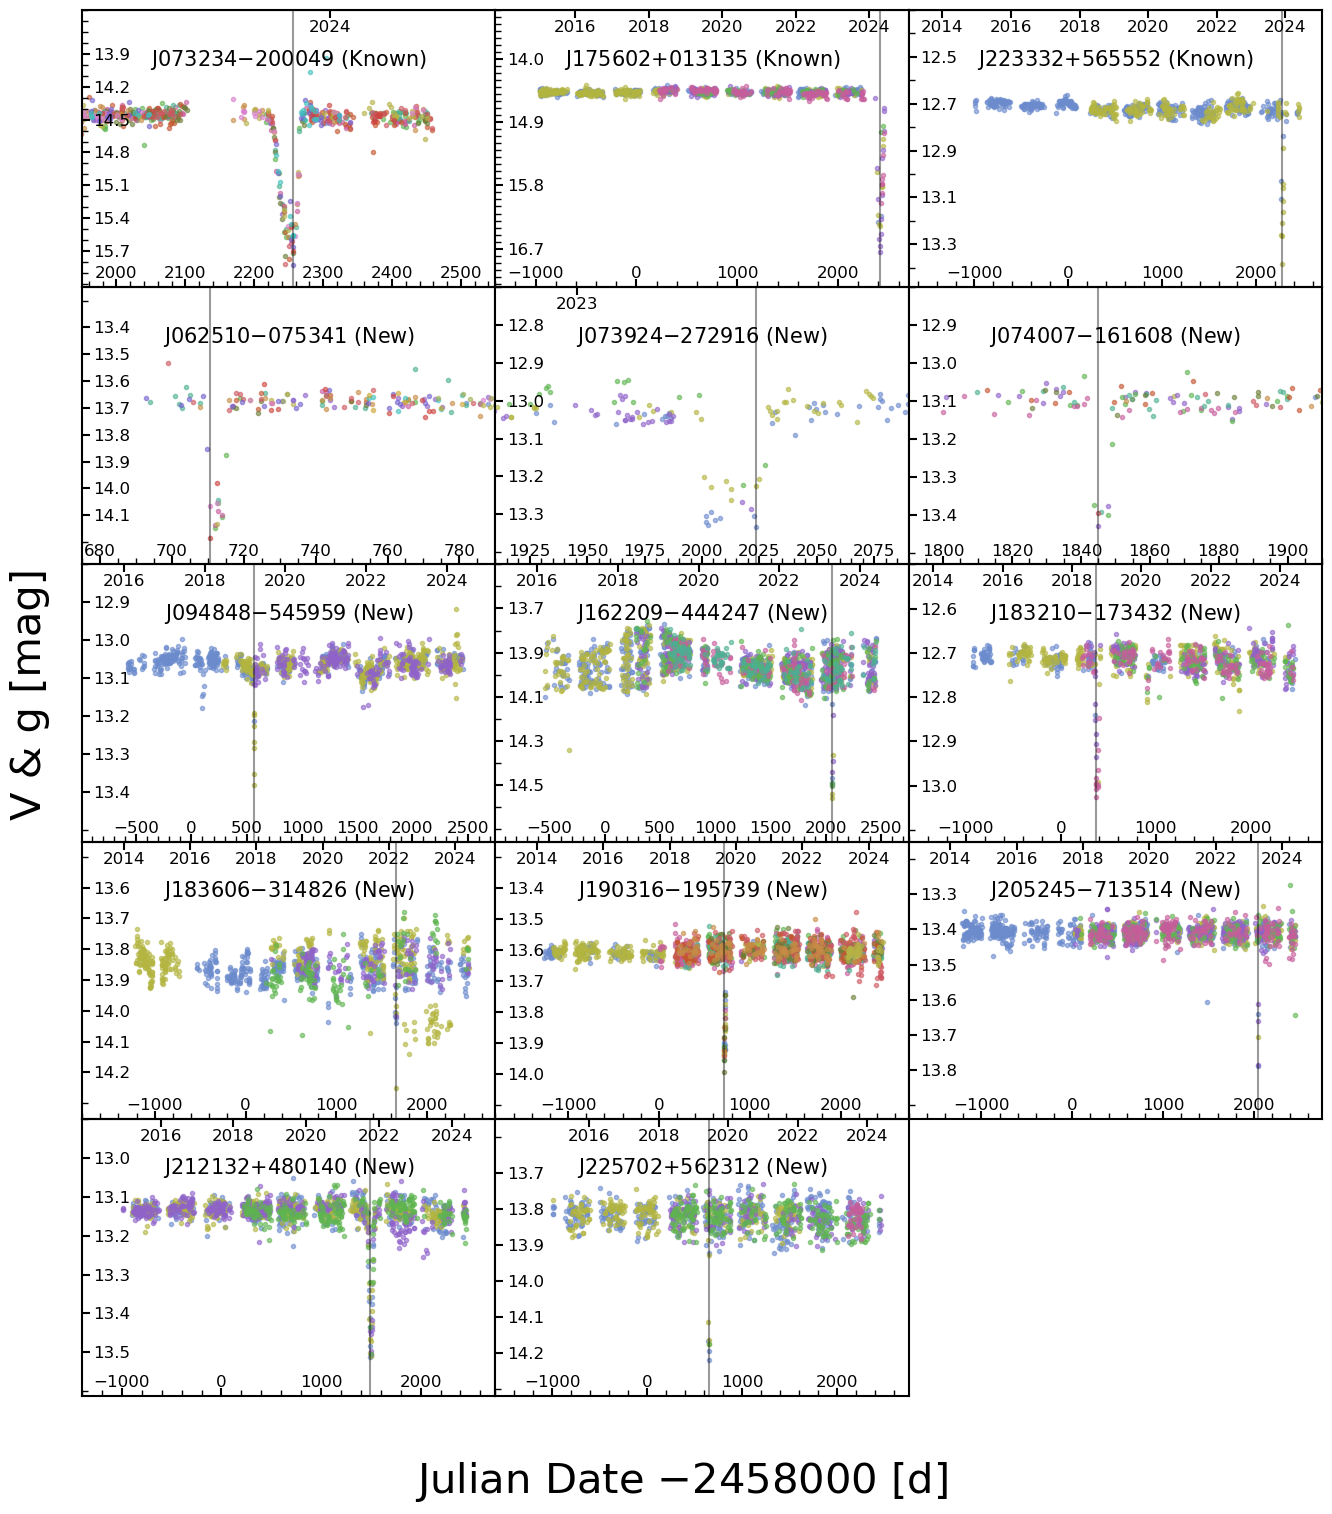

In [23]:
fig = plt.figure(figsize=(16,18))
gs = fig.add_gridspec(5,3,hspace=0,wspace=0)
ax = gs.subplots(sharex=False,sharey=False)

padnum = -40

titlesize = 15

# Subfig 1 (335007754417) (J073234-200049)
cams = J0720v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0720 = J0720v.loc[J0720v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0720["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0720["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0720g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0720 = J0720g.loc[J0720g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0720["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0720["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0720)-2):
    ax[0,0].vlines((J0720g.JD[peak_J0720[i+2]] - (2.458 * 10**6)), 13.5, (max(J0720g['Mag'])+0.2), "k", alpha=0.4)

ax[0,0].set_title(J0720_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,0].set_xlim(1950,2550)
ax[0,0].set_ylim(13.5,(max(J0720g['Mag'])+0.2))
ax[0,0].set_yticks(np.linspace(13.9, 15.7, 7))
secax0 = ax[0,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax0.set_xticks(np.arange(2019, 2026)) 
secax0.set_xticklabels([str(year) for year in range(2019, 2026)])
secax0.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 2 (231929175915) (J175602+013135)
cams = J1701v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1701 = J1701v.loc[J1701v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1701["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1701["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1701g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1701 = J1701g.loc[J1701g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1701["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1701["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1701)):
    ax[0,1].vlines((J1701g.JD[peak_J1701[i]] - (2.458 * 10**6)), 13.3, (max(J1701g['Mag'])+0.5), "k", alpha=0.4)

ax[0,1].set_title(J1701_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,1].set_xlim(-1400,2700)
ax[0,1].set_ylim(13.3,(max(J1701g['Mag'])+0.5))
ax[0,1].set_yticks(np.linspace(14, 16.7, 4))
secax1 = ax[0,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 3 (60130040391) (J223332+565552)
J225655v = J225655v.loc[J225655v['Mag'] < 13.8].reset_index(drop=True)
J225655g = J225655g.loc[J225655g['Mag'] < 13.8].reset_index(drop=True)

cams = J225655v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225655 = J225655v.loc[J225655v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225655["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225655["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J225655g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225655 = J225655g.loc[J225655g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225655["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225655["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J225655)-1):
    ax[0,2].vlines((J225655g.JD[peak_J225655[i+1]] - (2.458 * 10**6)), 12.3, (max(J225655g['Mag'])+0.1), "k", alpha=0.4)

ax[0,2].set_title(J225655_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,2].set_xlim(-1700,2700)
ax[0,2].set_ylim(12.3,(max(J225655g['Mag'])+0.1))
ax[0,2].set_yticks(np.linspace(12.5, 13.3, 5))
secax2 = ax[0,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax2.set_xticks(np.arange(2014, 2026, 2))  
secax2.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax2.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 4 (J062510-075341)	(377958261591)
cams = J0607v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0607 = J0607v.loc[J0607v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0607["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0607["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0607g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0607 = J0607g.loc[J0607g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0607["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0607["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0607)):
    ax[1,0].vlines((J0607g.JD[peak_J0607[i]] - (2.458 * 10**6)), 13.25, (max(J0607g['Mag'])+0.1), "k", alpha=0.4)

ax[1,0].set_title(J0607_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,0].set_xlim(675,790)
ax[1,0].set_ylim(13.25,(max(J0607g['Mag'])+0.1))
ax[1,0].set_yticks(np.linspace(13.4, 14.1, 8))
secax3 = ax[1,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax3.set_xticks(np.arange(2014, 2026, 1))  
secax3.set_xticklabels([str(year) for year in range(2014, 2026, 1)])
secax3.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 5 (J073924-272916)	(438086977939)
cams = J0727v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0727 = J0727v.loc[J0727v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0727["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0727["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0727g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0727 = J0727g.loc[J0727g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0727["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0727["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0727)):
    ax[1,1].vlines((J0727g.JD[peak_J0727[i]] - (2.458 * 10**6)), 12.7, (max(J0727g['Mag'])+0.1), "k", alpha=0.4)

ax[1,1].set_title(J0727_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,1].set_xlim(1910,2090)
ax[1,1].set_ylim(12.7,(max(J0727g['Mag'])+0.1))
ax[1,1].set_yticks(np.linspace(12.8, 13.3, 6))
secax4 = ax[1,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax4.set_xticks(np.arange(2014, 2026, 1))  
secax4.set_xticklabels([str(year) for year in range(2014, 2026, 1)])
secax4.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 6 (J074007-161608)	(360777377116)
J0716g = J0716g.loc[J0716g['Mag'] < 13.75].reset_index(drop=True)
J0716v = J0716v.loc[J0716v['Mag'] < 13.75].reset_index(drop=True)

cams = J0716v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0716 = J0716v.loc[J0716v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0716["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0716["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0716g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0716 = J0716g.loc[J0716g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0716["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0716["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0716)-1):
    ax[1,2].vlines((J0716g.JD[peak_J0716[i]] - (2.458 * 10**6)), 12.8, (max(J0716g['Mag'])+0.1), "k", alpha=0.4)

ax[1,2].set_title(J0716_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,2].set_xlim(1790,1910)
ax[1,2].set_ylim(12.8,(max(J0716g['Mag'])+0.1))
ax[1,2].set_yticks(np.linspace(12.9, 13.4, 6))
secax5 = ax[1,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax5.set_xticks(np.arange(2014, 2026, 1))  
secax5.set_xticklabels([str(year) for year in range(2014, 2026, 1)])
secax5.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 7 (J094848-545959)	(635655234580)
cams = J0954v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0954 = J0954v.loc[J0954v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0954["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0954["Mag"].astype(float)
    ax[2,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0954g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0954 = J0954g.loc[J0954g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0954["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0954["Mag"].astype(float)
    ax[2,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0954)):
    ax[2,0].vlines((J0954g.JD[peak_J0954[i]] - (2.458 * 10**6)), 12.8, (max(J0954g['Mag'])+0.15), "k", alpha=0.4)

ax[2,0].set_title(J0954_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,0].set_xlim(-990,2750)
ax[2,0].set_ylim(12.8,(max(J0954g['Mag'])+0.15))
ax[2,0].set_yticks(np.linspace(12.9, 13.4, 6))
secax6 = ax[2,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax6.set_xticks(np.arange(2014, 2026, 2))  
secax6.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax6.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 8 (J162209-444247)	(412317159120)
cams = J1644v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1644 = J1644v.loc[J1644v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1644["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1644["Mag"].astype(float)
    ax[2,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1644g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1644 = J1644g.loc[J1644g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1644["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1644["Mag"].astype(float)
    ax[2,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1644)):
    ax[2,1].vlines((J1644g.JD[peak_J1644[i]] - (2.458 * 10**6)), 13.5, (max(J1644g['Mag'])+0.2), "k", alpha=0.4)

ax[2,1].set_title(J1644_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,1].set_xlim(-990,2750)
ax[2,1].set_ylim(13.5,(max(J1644g['Mag'])+0.2))
ax[2,1].set_yticks(np.linspace(13.7, 14.5, 5))
secax7 = ax[2,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax7.set_xticks(np.arange(2014, 2026, 2))  
secax7.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax7.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 9 (J183210-173432)	(317827964025)
cams = J1817v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1817 = J1817v.loc[J1817v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1817["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1817["Mag"].astype(float)
    ax[2,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1817g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1817 = J1817g.loc[J1817g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1817["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1817["Mag"].astype(float)
    ax[2,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1817)):
    ax[2,2].vlines((J1817g.JD[peak_J1817[i]] - (2.458 * 10**6)), 12.5, (max(J1817g['Mag'])+0.1), "k", alpha=0.4)

ax[2,2].set_title(J1817_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,2].set_xlim(-1600,2750)
ax[2,2].set_ylim(12.5,(max(J1817g['Mag'])+0.1))
ax[2,2].set_yticks(np.linspace(12.6, 13, 5))
secax8 = ax[2,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax8.set_xticks(np.arange(2014, 2026, 2))  
secax8.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax8.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 10 (J183606-314826)	(438086901547)
J1831v = J1831v.loc[J1831v['Mag'] < 14.5].reset_index(drop=True)
J1831g = J1831g.loc[J1831g['Mag'] < 14.5].reset_index(drop=True)

cams = J1831v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1831 = J1831v.loc[J1831v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1831["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1831["Mag"].astype(float)
    ax[3,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1831g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1831 = J1831g.loc[J1831g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1831["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1831["Mag"].astype(float)
    ax[3,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1831)):
    ax[3,0].vlines((J1831g.JD[peak_J1831[i]] - (2.458 * 10**6)), 13.45, (max(J1831g['Mag'])+0.1), "k", alpha=0.4)

ax[3,0].set_title(J1831_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,0].set_xlim(-1800,2750)
ax[3,0].set_ylim(13.45,(max(J1831g['Mag'])+0.1))
ax[3,0].set_yticks(np.linspace(13.6, 14.2, 7))
secax9 = ax[3,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax9.set_xticks(np.arange(2014, 2026, 2))  
secax9.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax9.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 11 (J190316-195739)	(515396514761)
cams = J1919v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1919 = J1919v.loc[J1919v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1919["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1919["Mag"].astype(float)
    ax[3,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1919g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1919 = J1919g.loc[J1919g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1919["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1919["Mag"].astype(float)
    ax[3,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1919)):
    ax[3,1].vlines((J1919g.JD[peak_J1919[i]] - (2.458 * 10**6)), 13.25, (max(J1919g['Mag'])+0.15), "k", alpha=0.4)

ax[3,1].set_title(J1919_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,1].set_xlim(-1800,2750)
ax[3,1].set_ylim(13.25,(max(J1919g['Mag'])+0.15))
ax[3,1].set_yticks(np.linspace(13.4, 14, 7))
secax10 = ax[3,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax10.set_xticks(np.arange(2014, 2026, 2))  
secax10.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax10.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 12 (J205245-713514)	(463856535113)
cams = J2071v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2071 = J2071v.loc[J2071v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2071["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2071["Mag"].astype(float)
    ax[3,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J2071g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2071 = J2071g.loc[J2071g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2071["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2071["Mag"].astype(float)
    ax[3,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J2071)):
    ax[3,2].vlines((J2071g.JD[peak_J2071[i]] - (2.458 * 10**6)), 13.15, (max(J2071g['Mag'])+0.15), "k", alpha=0.4)

ax[3,2].set_title(J2071_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,2].set_xlim(-1800,2750)
ax[3,2].set_ylim(13.15,(max(J2071g['Mag'])+0.15))
ax[3,2].set_yticks(np.linspace(13.3, 13.8, 6))
secax11 = ax[3,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax11.set_xticks(np.arange(2014, 2026, 2))  
secax11.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax11.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 13 (J212132+480140) (120259184943)
cams = J2148v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2148 = J2148v.loc[J2148v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2148["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2148["Mag"].astype(float)
    ax[4,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J2148g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2148 = J2148g.loc[J2148g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2148["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2148["Mag"].astype(float)
    ax[4,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J2148)):
    ax[4,0].vlines((J2148g.JD[peak_J2148[i]] - (2.458 * 10**6)), 12.9, (max(J2148g['Mag'])+0.1), "k", alpha=0.4)

ax[4,0].set_title(J2148_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[4,0].set_xlim(-1400,2750)
ax[4,0].set_ylim(12.9,(max(J2148g['Mag'])+0.1))
ax[4,0].set_yticks(np.linspace(13, 13.5, 6))
secax12 = ax[4,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax12.set_xticks(np.arange(2016, 2026, 2))  
secax12.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax12.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 14 (J225702+562312) (25770019815)
cams = J225623v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225623 = J225623v.loc[J225623v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225623["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225623["Mag"].astype(float)
    ax[4,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J225623g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ225623 = J225623g.loc[J225623g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ225623["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ225623["Mag"].astype(float)
    ax[4,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J225623)):
    ax[4,1].vlines((J225623g.JD[peak_J225623[i]] - (2.458 * 10**6)), 13.55, (max(J225623g['Mag'])+0.1), "k", alpha=0.4)

ax[4,1].set_title(J225623_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[4,1].set_xlim(-1600,2750)
ax[4,1].set_ylim(13.55,(max(J225623g['Mag'])+0.1))
ax[4,1].set_yticks(np.linspace(13.7, 14.2, 6))
secax13 = ax[4,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax13.set_xticks(np.arange(2016, 2026, 2))  
secax13.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax13.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

ax[4,2].set_visible(False)

for axe in ax.flatten():
    axe.invert_yaxis()
    axe.minorticks_on()
    axe.tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
    axe.tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
    axe.tick_params('both', length=6, width=1.5, which='major')
    axe.tick_params('both', direction='in', length=4, width=1, which='minor')
    axe.yaxis.set_minor_locator(tick.MultipleLocator(0.1))
    #secax = axe.secondary_xaxis('top', functions=(jd_to_year,year_to_jd))
    #secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5) 
    for axis in ['top', 'bottom', 'left', 'right']:
        axe.spines[axis].set_linewidth(1.5)

fig.supxlabel('Julian Date $- 2458000$ [d]', fontsize=30, y=0.05)
fig.supylabel('V & g [mag]', fontsize=30, x=0.08)

In [24]:
# J005437+644347																																
asassn_id = 68720274411
ra_val = 13.652625
dec_val = 64.72975	

J0064_id = custom_id(ra_val,dec_val)

J0064v, J0064g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J0064g = J0064g.loc[J0064g.Mag < 15].reset_index(drop=True)

mean0064 = np.mean(J0064g['Mag'])

J0064_mag_avg = [i - mean0064 for i in J0064g['Mag']]

peaks_J0064 = scipy.signal.find_peaks(J0064_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0064 = peaks_J0064[0]

peak_J0064 = [int(i) for i in peak_J0064]

peak_J0064 = pd.Series(peak_J0064)

In [25]:
# J181752-580749																																			
asassn_id = 644245387906
ra_val = 274.4647083
dec_val = -58.13033333	

J1858_id = custom_id(ra_val,dec_val)

J1858v, J1858g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J1858g = J1858g.loc[J1858g['Mag'] < 15].reset_index(drop=True)

mean1858 = np.mean(J1858g['Mag'])

J1858_mag_avg = [i - mean1858 for i in J1858g['Mag']]

peaks_J1858 = scipy.signal.find_peaks(J1858_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1858 = peaks_J1858[0]

peak_J1858 = [int(i) for i in peak_J1858]

peak_J1858 = pd.Series(peak_J1858)

In [26]:
# J005255+633515																																					
asassn_id = 94489418658
ra_val = 13.22923194
dec_val = 63.58755732	

J0063_id = custom_id(ra_val,dec_val)

J0063v, J0063g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J0063g = J0063g.loc[J0063g['Mag'] < 15].reset_index(drop=True)

mean0063 = np.mean(J0063g['Mag'])

J0063_mag_avg = [i - mean0063 for i in J0063g['Mag']]

peaks_J0063 = scipy.signal.find_peaks(J0063_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0063 = peaks_J0063[0]

peak_J0063 = [int(i) for i in peak_J0063]

peak_J0063 = pd.Series(peak_J0063)

In [27]:
# J124745-622756																																								
asassn_id = 515397118400
ra_val = 191.9366145
dec_val = -62.4654549	

J1262_id = custom_id(ra_val,dec_val)

J1262v, J1262g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1262 = np.mean(J1262g['Mag'])

J1262_mag_avg = [i - mean1262 for i in J1262g['Mag']]

peaks_J1262 = scipy.signal.find_peaks(J1262_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1262 = peaks_J1262[0]

peak_J1262 = [int(i) for i in peak_J1262]

peak_J1262 = pd.Series(peak_J1262)

In [28]:
# J160757-574540																																											
asassn_id = 661425129485
ra_val = 241.9885247
dec_val = -57.76106277	

J1657_id = custom_id(ra_val,dec_val)

J1657v, J1657g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1657 = np.mean(J1657g['Mag'])

J1657_mag_avg = [i - mean1657 for i in J1657g['Mag']]

peaks_J1657 = scipy.signal.find_peaks(J1657_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1657 = peaks_J1657[0]

peak_J1657 = [int(i) for i in peak_J1657]

peak_J1657 = pd.Series(peak_J1657)

In [29]:
# J175912-120956																																														
asassn_id = 326417831663
ra_val = 269.7994218
dec_val = -12.16566391	

J1712_id = custom_id(ra_val,dec_val)

J1712v, J1712g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1712 = np.mean(J1712g['Mag'])

J1712_mag_avg = [i - mean1712 for i in J1712g['Mag']]

peaks_J1712 = scipy.signal.find_peaks(J1712_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1712 = peaks_J1712[0]

peak_J1712 = [int(i) for i in peak_J1712]

peak_J1712 = pd.Series(peak_J1712)

Text(0.08, 0.5, 'V & g [mag]')

/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 2 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


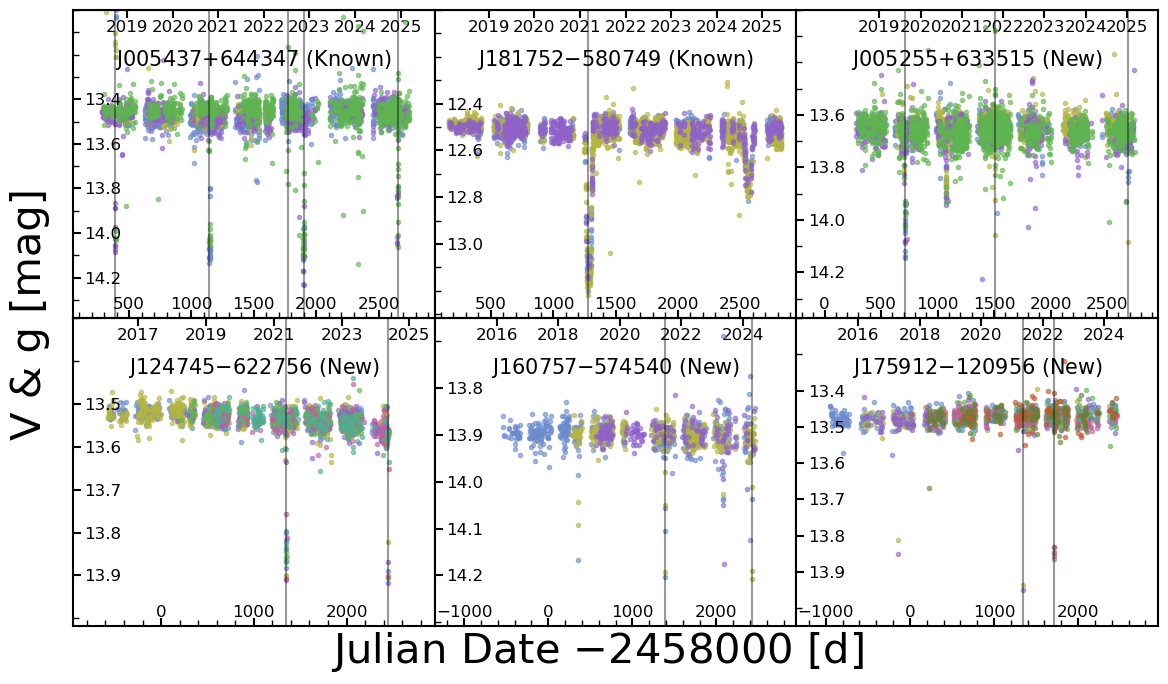

In [30]:
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2,3,hspace=0,wspace=0)
ax = gs.subplots(sharex=False,sharey=False)

padnum = -40

titlesize = 15

# Subfig 1 (68720274411) (J005437+644347)
cams = J0064v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0064 = J0064v.loc[J0064v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0064["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0064["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0064g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0064 = J0064g.loc[J0064g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0064["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0064["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0064)):
    ax[0,0].vlines((J0064g.JD[peak_J0064[i]] - (2.458 * 10**6)), 13, (max(J0064g['Mag'])+0.15), "k", alpha=0.4)

ax[0,0].set_title(J0064_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,0].set_xlim(50,2950)
ax[0,0].set_ylim(13,(max(J0064g['Mag'])+0.15))
ax[0,0].set_yticks(np.linspace(13.4, 14.2, 5))
secax0 = ax[0,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax0.set_xticks(np.arange(2019, 2026, 1))  
secax0.set_xticklabels([str(year) for year in range(2019, 2026, 1)])
secax0.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 2 (644245387906) (J181752-580749)
cams = J1858v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1858 = J1858v.loc[J1858v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1858["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1858["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1858g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1858 = J1858g.loc[J1858g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1858["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1858["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1858)):
    ax[0,1].vlines((J1858g.JD[peak_J1858[i]] - (2.458 * 10**6)), 12, (max(J1858g['Mag'])+0.1), "k", alpha=0.4)

ax[0,1].set_title(J1858_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,1].set_xlim(50,2950)
ax[0,1].set_ylim(12,(max(J1858g['Mag'])+0.1))
ax[0,1].set_yticks(np.linspace(12.4, 13, 4))
secax1 = ax[0,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2019, 2026, 1))  
secax1.set_xticklabels([str(year) for year in range(2019, 2026, 1)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 3 (94489418658) (J005255+633515)
cams = J0063v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0063 = J0063v.loc[J0063v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0063["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0063["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0063g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0063 = J0063g.loc[J0063g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0063["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0063["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0063)):
    ax[0,2].vlines((J0063g.JD[peak_J0063[i]] - (2.458 * 10**6)), 13, (max(J0063g['Mag'])+0.15), "k", alpha=0.4)

ax[0,2].set_title(J0063_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[0,2].set_xlim(-250,2950)
ax[0,2].set_ylim(13.2,(max(J0063g['Mag'])+0.15))
ax[0,2].set_yticks(np.linspace(13.6, 14.2, 4))
secax1 = ax[0,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2019, 2026, 1))  
secax1.set_xticklabels([str(year) for year in range(2019, 2026, 1)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 4 (J124745-622756) (515397118400)
cams = J1262v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1262 = J1262v.loc[J1262v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1262["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1262["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1262g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1262 = J1262g.loc[J1262g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1262["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1262["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1262)):
    ax[1,0].vlines((J1262g.JD[peak_J1262[i]] - (2.458 * 10**6)), 13.3, (max(J1262g['Mag'])+0.1), "k", alpha=0.4)

ax[1,0].set_title(J1262_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,0].set_xlim(-950,2950)
ax[1,0].set_ylim(13.3,(max(J1262g['Mag'])+0.1))
ax[1,0].set_yticks(np.linspace(13.5, 13.9, 5))
secax1 = ax[1,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2017, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2017, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 5 (J160757-574540) (661425129485)
cams = J1657v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1657 = J1657v.loc[J1657v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1657["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1657["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1657g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1657 = J1657g.loc[J1657g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1657["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1657["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1657)):
    ax[1,1].vlines((J1657g.JD[peak_J1657[i]] - (2.458 * 10**6)), 13.65, (max(J1657g['Mag'])+0.1), "k", alpha=0.4)

ax[1,1].set_title(J1657_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,1].set_xlim(-1350,2950)
ax[1,1].set_ylim(13.65,(max(J1657g['Mag'])+0.1))
ax[1,1].set_yticks(np.linspace(13.8, 14.2, 5))
secax1 = ax[1,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 6 (J175912-120956) (326417831663)
cams = J1712v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1712 = J1712v.loc[J1712v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1712["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1712["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1712g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1712 = J1712g.loc[J1712g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1712["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1712["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1712)):
    ax[1,2].vlines((J1712g.JD[peak_J1712[i]] - (2.458 * 10**6)), 13.2, (max(J1712g['Mag'])+0.1), "k", alpha=0.4)

ax[1,2].set_title(J1712_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[1,2].set_xlim(-1350,2950)
ax[1,2].set_ylim(13.2,(max(J1712g['Mag'])+0.1))
ax[1,2].set_yticks(np.linspace(13.4, 13.9, 6))
secax1 = ax[1,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

for axe in ax.flatten():
    axe.invert_yaxis()
    axe.minorticks_on()
    axe.tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
    axe.tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
    axe.tick_params('both', length=6, width=1.5, which='major')
    axe.tick_params('both', direction='in', length=4, width=1, which='minor')
    axe.yaxis.set_minor_locator(tick.MultipleLocator(0.1))
    for axis in ['top', 'bottom', 'left', 'right']:
        axe.spines[axis].set_linewidth(1.5)

fig.supxlabel('Julian Date $- 2458000$ [d]', fontsize=30, y=0.05)
fig.supylabel('V & g [mag]', fontsize=30, x=0.08)

In [31]:
# J070519+061219																																								
asassn_id = 266288137752
ra_val = 106.32899
dec_val = 6.205306	

J0706_id = custom_id(ra_val,dec_val)

J0706v, J0706g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J0706g = J0706g.loc[J0706g['Mag'] < 20].reset_index(drop=True)

mean0706 = np.mean(J0706g['Mag'])

J0706_mag_avg = [i - mean0706 for i in J0706g['Mag']]

peaks_J0706 = scipy.signal.find_peaks(J0706_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0706 = peaks_J0706[0]

peak_J0706 = [int(i) for i in peak_J0706]

peak_J0706 = pd.Series(peak_J0706)

In [32]:
# J081523-385923																																											
asassn_id = 532576686103
ra_val = 123.8475
dec_val = -38.98980556	

J0838_id = custom_id(ra_val,dec_val)

J0838v, J0838g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0838 = np.mean(J0838g['Mag'])

J0838_mag_avg = [i - mean0838 for i in J0838g['Mag']]

peaks_J0838 = scipy.signal.find_peaks(J0838_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0838 = peaks_J0838[0]

peak_J0838 = [int(i) for i in peak_J0838]

peak_J0838 = pd.Series(peak_J0838)

In [33]:
# J085816-430955 																																													
asassn_id = 352187470767
ra_val = 134.56485
dec_val = -43.16532		

J0843_id = custom_id(ra_val,dec_val)

J0843v, J0843g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J0843g = J0843g.loc[J0843g.Mag < 20].reset_index(drop=True)

mean0843 = np.mean(J0843g['Mag'])

J0843_mag_avg = [i - mean0843 for i in J0843g['Mag']]

peaks_J0843 = scipy.signal.find_peaks(J0843_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0843 = peaks_J0843[0]

peak_J0843 = [int(i) for i in peak_J0843]

peak_J0843 = pd.Series(peak_J0843)

In [34]:
# J114712-621037			 																																													
asassn_id = 609886184506
ra_val = 176.7999167
dec_val = -62.17702778		

J1162_id = custom_id(ra_val,dec_val)

J1162v, J1162g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1162 = np.mean(J1162g['Mag'])

J1162_mag_avg = [i - mean1162 for i in J1162g['Mag']]

peaks_J1162 = scipy.signal.find_peaks(J1162_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1162 = peaks_J1162[0]

peak_J1162 = [int(i) for i in peak_J1162]

peak_J1162 = pd.Series(peak_J1162)

In [35]:
# J183153-284827						 																																													
asassn_id = 455267102087
ra_val = 277.96999
dec_val = -28.80754		

J1828_id = custom_id(ra_val,dec_val)

J1828v, J1828g = read_lightcurve_csv(asassn_id, 'Updated_LC_data/')

J1828g = J1828g.loc[J1828g['Mag'] < 20].reset_index(drop=True)

mean1828 = np.mean(J1828g['Mag'])

J1828_mag_avg = [i - mean1828 for i in J1828g['Mag']]

peaks_J1828 = scipy.signal.find_peaks(J1828_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1828 = peaks_J1828[0]

peak_J1828 = [int(i) for i in peak_J1828]

peak_J1828 = pd.Series(peak_J1828)

In [36]:
# J184916-473251									 																																													
asassn_id = 472447294641
ra_val = 282.31475
dec_val = -47.54741667		

J1847_id = custom_id(ra_val,dec_val)

J1847v, J1847g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

J1847g['Mag'].astype(float)

mean1847 = np.mean(J1847g['Mag'])

J1847_mag_avg = [i - mean1847 for i in J1847g['Mag']]

peaks_J1847 = scipy.signal.find_peaks(J1847_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1847 = peaks_J1847[0]

peak_J1847 = [int(i) for i in peak_J1847]

peak_J1847 = pd.Series(peak_J1847)

In [37]:
# J042214+152530												 																																													
asassn_id = 377957522430
ra_val = 65.55736276
dec_val = 15.42493885		

J0415_id = custom_id(ra_val,dec_val)

J0415v, J0415g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0415 = np.mean(J0415g['Mag'])

J0415_mag_avg = [i - mean0415 for i in J0415g['Mag']]

peaks_J0415 = scipy.signal.find_peaks(J0415_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0415 = peaks_J0415[0]

peak_J0415 = [int(i) for i in peak_J0415]

peak_J0415 = pd.Series(peak_J0415)

In [38]:
# J080327-261620															 																																													
asassn_id = 601296043597
ra_val = 120.8622157
dec_val = -26.27215412		

J0826_id = custom_id(ra_val,dec_val)

J0826v, J0826g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean0826 = np.mean(J0826g['Mag'])

J0826_mag_avg = [i - mean0826 for i in J0826g['Mag']]

peaks_J0826 = scipy.signal.find_peaks(J0826_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J0826 = peaks_J0826[0]

peak_J0826 = [int(i) for i in peak_J0826]

peak_J0826 = pd.Series(peak_J0826)

In [39]:
# J174328+343315																		 																																													
asassn_id = 223339338105
ra_val = 265.8684124
dec_val = 34.55405423		

J1734_id = custom_id(ra_val,dec_val)

J1734v, J1734g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean1734 = np.mean(J1734g['Mag'])

J1734_mag_avg = [i - mean1734 for i in J1734g['Mag']]

peaks_J1734 = scipy.signal.find_peaks(J1734_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J1734 = peaks_J1734[0]

peak_J1734 = [int(i) for i in peak_J1734]

peak_J1734 = pd.Series(peak_J1734)

In [40]:
# J202402+383938																					 																																													
asassn_id = 42950993887
ra_val = 306.0094122
dec_val = 38.66055087		

J2038_id = custom_id(ra_val,dec_val)

J2038v, J2038g = read_lightcurve_dat(asassn_id, 'Updated_LC_data/')

mean2038 = np.mean(J2038g['Mag'])

J2038_mag_avg = [i - mean2038 for i in J2038g['Mag']]

peaks_J2038 = scipy.signal.find_peaks(J2038_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_J2038 = peaks_J2038[0]

peak_J2038 = [int(i) for i in peak_J2038]

peak_J2038 = pd.Series(peak_J2038)

Text(0.08, 0.5, 'V & g [mag]')

/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 2 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


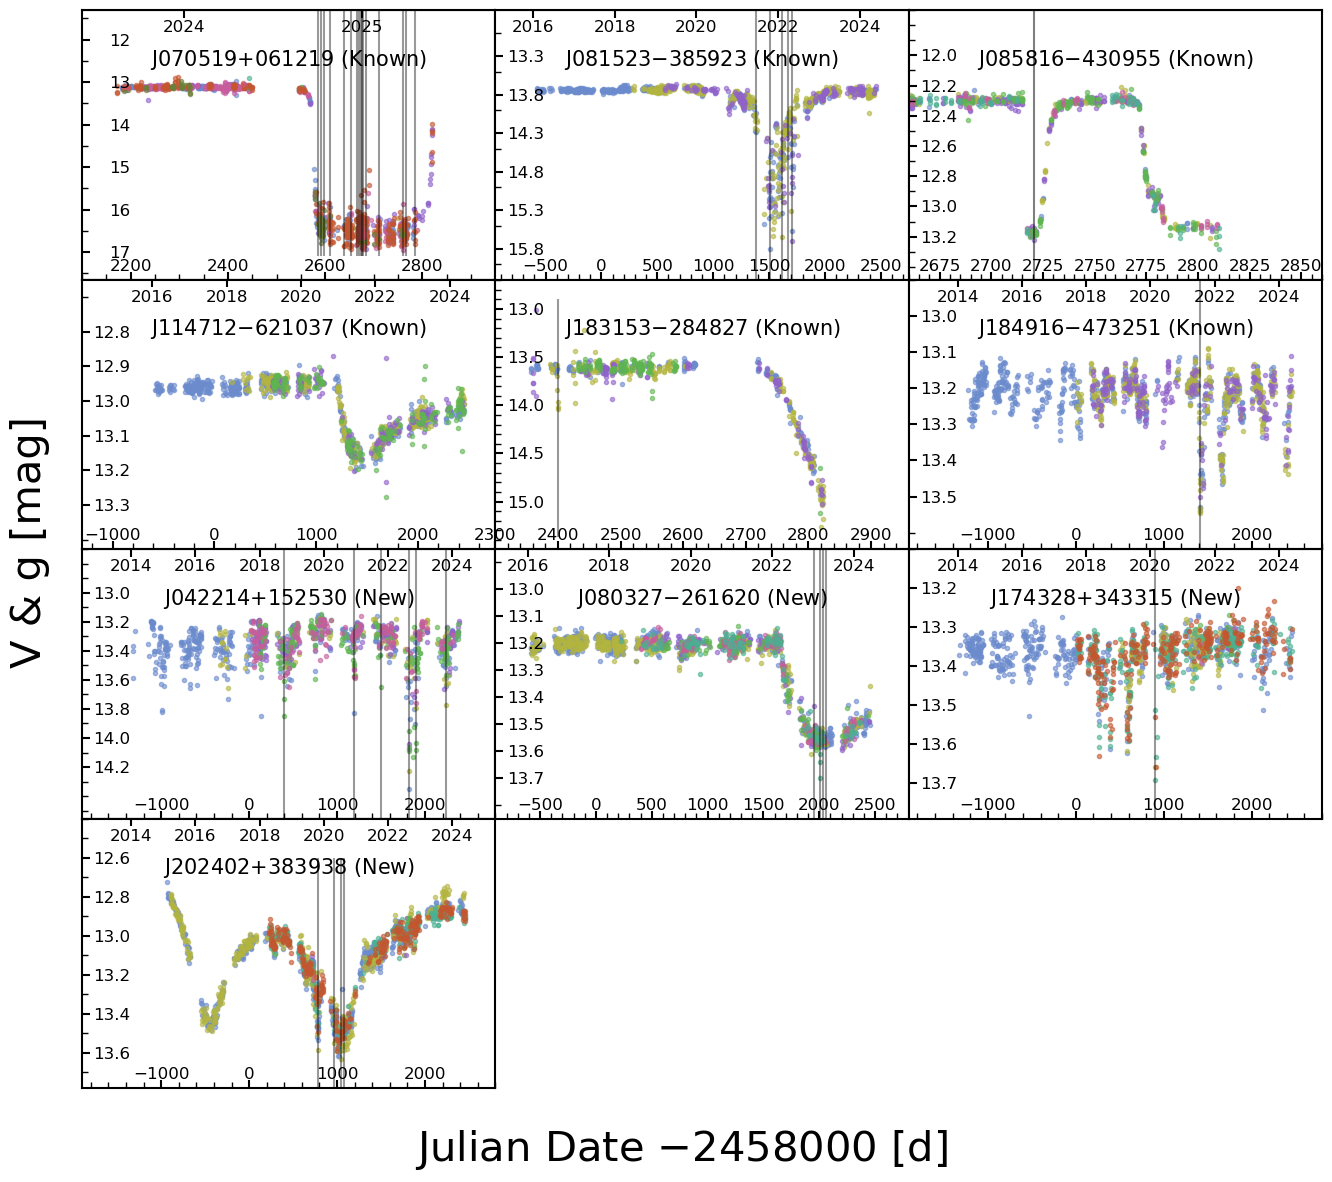

In [55]:
fig = plt.figure(figsize=(16,14))
gs = fig.add_gridspec(4,3,hspace=0,wspace=0)
ax = gs.subplots(sharex=False,sharey=False)

padnum = -40

titlesize = 15

# Subfig 1 (266288137752) (J070519+061219)
cams = J0706v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0706 = J0706v.loc[J0706v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0706["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0706["Mag"].astype(float) + 0.25
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0706g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0706 = J0706g.loc[J0706g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0706["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0706["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0706)):
    ax[0,0].vlines((J0706g.JD[peak_J0706[i]] - (2.458 * 10**6)), 11.3, (max(J0706g['Mag'])+0.15), "k", alpha=0.4)

ax[0,0].set_title(J0706_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,0].set_xlim(2100,2950)
ax[0,0].set_ylim(11.3,(max(J0706g['Mag'])+0.7))
#ax[0,0].set_yticks(np.linspace(13.2, 14, 5))
ax[0,0].invert_yaxis()
ax[0,0].minorticks_on()
ax[0,0].yaxis.set_minor_locator(tick.MultipleLocator(0.5))
secax1 = ax[0,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 1))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 1)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 2 (532576686103) (J081523-385923)
cams = J0838v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0838 = J0838v.loc[J0838v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0838["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0838["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0838g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0838 = J0838g.loc[J0838g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0838["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0838["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0838)):
    ax[0,1].vlines((J0838g.JD[peak_J0838[i]] - (2.458 * 10**6)), 12.7, (max(J0838g['Mag'])+0.4), "k", alpha=0.4)

ax[0,1].set_title(J0838_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,1].set_xlim(-950,2750)
ax[0,1].set_ylim(12.7,(max(J0838g['Mag'])+0.4))
ax[0,1].set_yticks(np.linspace(13.3, 15.8, 6))
ax[0,1].invert_yaxis()
ax[0,1].minorticks_on()
ax[0,1].yaxis.set_minor_locator(tick.MultipleLocator(0.5))
secax1 = ax[0,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 3 (352187470767) (J085816-430955)
J0843v = J0843v.loc[J0843v['mag'] < 20].reset_index(drop=True)
J0843g = J0843g.loc[J0843g['mag'] < 20].reset_index(drop=True)

cams = J0843v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0843 = J0843v.loc[J0843v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0843["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0843["Mag"].astype(float) + 0.3
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0843g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0843 = J0843g.loc[J0843g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0843["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0843["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0843)):
    ax[0,2].vlines((J0843g.JD[peak_J0843[i]] - (2.458 * 10**6)), 11.7, (max(J0843g['Mag'])+0.2), "k", alpha=0.5)

ax[0,2].set_title(J0843_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,2].set_xlim(2660,2860)
ax[0,2].set_ylim(11.7,(max(J0843g['Mag'])+0.2))
ax[0,2].set_yticks(np.linspace(12, 13.2, 7))
ax[0,2].invert_yaxis()
ax[0,2].minorticks_on()
ax[0,2].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[0,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 4 (609886184506) (J114712-621037)
cams = J1162v['Camera']
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1162 = J1162v.loc[J1162v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1162["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1162["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1162g["Camera"]
camtype = np.unique(cams)

camtype = np.delete(camtype, np.where(camtype == ['bE']))
camtype = np.delete(camtype, np.where(camtype == ['bi']))

camnum = len(camtype)

for i in range(0,camnum):
    camJ1162 = J1162g.loc[J1162g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1162["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1162["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1162)):
    ax[1,0].vlines((J1162g.JD[peak_J1162[i]] - (2.458 * 10**6)), 12.65, (max(J1162g['Mag'])+0.15), "k", alpha=0.4)

ax[1,0].set_title(J1162_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[1,0].set_xlim(-1300,2760)
ax[1,0].set_ylim(12.65,(max(J1162g['Mag'])+0.15))
ax[1,0].set_yticks(np.linspace(12.8, 13.3, 6))
ax[1,0].invert_yaxis()
ax[1,0].minorticks_on()
ax[1,0].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[1,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 5 (472447294641) (J183153-284827)
J1828v = J1828v.loc[J1828v.Mag < 20].reset_index(drop=True)

cams = J1828v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1828 = J1828v.loc[J1828v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1828["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1828["Mag"].astype(float) + 0.5
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1828g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1828 = J1828g.loc[J1828g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1828["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1828["Mag"].astype(float)
    ax[1,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1828)):
    ax[1,1].vlines((J1828g.JD[peak_J1828[i]] - (2.458 * 10**6)), 12.9, (max(J1828g['Mag'])+0.1), "k", alpha=0.4)

ax[1,1].set_title(J1828_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[1,1].set_xlim(2300,2960)
#ax[1,1].set_ylim(12.9,(max(J1828g['Mag'])+0.1))
#ax[1,1].set_yticks(np.linspace(13, 13.5, 6))
ax[1,1].invert_yaxis()
ax[1,1].minorticks_on()
ax[1,1].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
#secax1 = ax[1,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
#secax1.set_xticks(np.arange(2016, 2026, 2))  
#secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
#secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 6 (472447294641) (J184916-473251)
cams = J1847v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1847 = J1847v.loc[J1847v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1847["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1847["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1847g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1847 = J1847g.loc[J1847g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1847["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1847["Mag"].astype(float)
    ax[1,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1847)):
    ax[1,2].vlines((J1847g.JD[peak_J1847[i]] - (2.458 * 10**6)), 12.9, (max(J1847g['Mag'])+0.1), "k", alpha=0.4)

ax[1,2].set_title(J1847_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[1,2].set_xlim(-1900,2800)
ax[1,2].set_ylim(12.9,(max(J1847g['Mag'])+0.1))
ax[1,2].set_yticks(np.linspace(13, 13.5, 6))
ax[1,2].invert_yaxis()
ax[1,2].minorticks_on()
ax[1,2].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[1,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2014, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 7 (J042214+152530) (377957522430)
cams = J0415v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0415 = J0415v.loc[J0415v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0415["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0415["Mag"].astype(float)
    ax[2,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0415g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0415 = J0415g.loc[J0415g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0415["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0415["Mag"].astype(float)
    ax[2,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0415)):
    ax[2,0].vlines((J0415g.JD[peak_J0415[i]] - (2.458 * 10**6)), 12.7, (max(J0415g['Mag'])+0.2), "k", alpha=0.4)

ax[2,0].set_title(J0415_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,0].set_xlim(-1900,2800)
ax[2,0].set_ylim(12.7,(max(J0415g['Mag'])+0.2))
ax[2,0].set_yticks(np.linspace(13, 14.2, 7))
ax[2,0].invert_yaxis()
ax[2,0].minorticks_on()
ax[2,0].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[2,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2014, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 8 (J080327-261620) (601296043597)
cams = J0826v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0826 = J0826v.loc[J0826v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0826["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0826["Mag"].astype(float)
    ax[2,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J0826g["Camera"]
camtype = np.unique(cams)

camtype = np.delete(camtype, np.where(camtype == ['bl']))
camtype = np.delete(camtype, np.where(camtype == ['bH']))

camnum = len(camtype)

for i in range(0,camnum):
    camJ0826 = J0826g.loc[J0826g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0826["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0826["Mag"].astype(float)
    ax[2,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J0826)):
    ax[2,1].vlines((J0826g.JD[peak_J0826[i]] - (2.458 * 10**6)), 12.85, (max(J0826g['Mag'])+0.15), "k", alpha=0.4)

ax[2,1].set_title(J0826_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,1].set_xlim(-900,2800)
ax[2,1].set_ylim(12.85,(max(J0826g['Mag'])+0.15))
ax[2,1].set_yticks(np.linspace(13, 13.7, 8))
ax[2,1].invert_yaxis()
ax[2,1].minorticks_on()
ax[2,1].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[2,1].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2016, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2016, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 9 (J174328+343315) (223339338105)
cams = J1734v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1734 = J1734v.loc[J1734v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1734["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1734["Mag"].astype(float)
    ax[2,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J1734g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ1734 = J1734g.loc[J1734g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1734["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1734["Mag"].astype(float)
    ax[2,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J1734)):
    ax[2,2].vlines((J1734g.JD[peak_J1734[i]] - (2.458 * 10**6)), 13.1, (max(J1734g['Mag'])+0.1), "k", alpha=0.4)

ax[2,2].set_title(J1734_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[2,2].set_xlim(-1900,2800)
ax[2,2].set_ylim(13.1,(max(J1734g['Mag'])+0.1))
ax[2,2].set_yticks(np.linspace(13.2, 13.7, 6))
ax[2,2].invert_yaxis()
ax[2,2].minorticks_on()
ax[2,2].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[2,2].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2014, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

# Subfig 10 (J202402+383938) (42950993887)
cams = J2038v["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2038 = J2038v.loc[J2038v["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2038["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2038["Mag"].astype(float)
    ax[3,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

cams = J2038g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ2038 = J2038g.loc[J2038g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ2038["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ2038["Mag"].astype(float)
    ax[3,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

for i in range(len(peak_J2038)):
    ax[3,0].vlines((J2038g.JD[peak_J2038[i]] - (2.458 * 10**6)), 12.6, (max(J2038g['Mag'])+0.15), "k", alpha=0.4)

ax[3,0].set_title(J2038_id + ' (New)', y=1.0, pad=padnum, size=titlesize)
ax[3,0].set_xlim(-1900,2800)
ax[3,0].set_ylim(12.4,(max(J2038g['Mag'])+0.15))
ax[3,0].set_yticks(np.linspace(12.6, 13.6, 6))
ax[3,0].invert_yaxis()
ax[3,0].minorticks_on()
ax[3,0].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
secax1 = ax[3,0].secondary_xaxis('top', functions=(jd_to_year, year_to_jd))
secax1.set_xticks(np.arange(2014, 2026, 2))  
secax1.set_xticklabels([str(year) for year in range(2014, 2026, 2)])
secax1.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)

ax[3,1].set_visible(False)
ax[3,2].set_visible(False)

for axe in ax.flatten():
    axe.tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
    axe.tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
    axe.tick_params('both', length=6, width=1.5, which='major')
    axe.tick_params('both', direction='in', length=4, width=1, which='minor') 
    for axis in ['top', 'bottom', 'left', 'right']:
        axe.spines[axis].set_linewidth(1.5)

fig.supxlabel('Julian Date $- 2458000$ [d]', fontsize=30, y=0.05)
fig.supylabel('V & g [mag]', fontsize=30, x=0.08)

In [ ]:
fig = plt.figure(figsize=(16,14))
gs = fig.add_gridspec(4,3,hspace=0,wspace=0)
ax = gs.subplots(sharex=False,sharey=False)

padnum = -40

titlesize = 15

# Subfig 1 (266288137752) (J070519+061219)
for i in range(len(peak_J0706)):
    ax[0,0].vlines((J0706g.JD[peak_J0706[i]] - (2.458 * 10**6)), 11.3, (max(J0706g['Mag'])+0.15), "k", alpha=0.4)

J0706g = J0706g.loc[J0706g.JD > 2000 + (2.458 * 10 ** 6)].reset_index(drop=True)

cams = J0706g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0706 = J0706g.loc[J0706g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0706["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0706["Mag"].astype(float)
    ax[0,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

ax[0,0].minorticks_on()
ax[0,0].tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
ax[0,0].tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
ax[0,0].tick_params('both', length=6, width=1.5, which='major')
ax[0,0].tick_params('both', direction='in', length=4, width=1, which='minor')
ax[0,0].yaxis.set_minor_locator(tick.MultipleLocator(0.5))
secax = ax[0,0].secondary_xaxis('top', functions=(jd_to_year,year_to_jd)) 
secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5)
secax.xaxis.set_minor_locator(tick.MultipleLocator(1))
for axis in ['top', 'bottom', 'left', 'right']:
    ax[0,0].spines[axis].set_linewidth(1.5)
ax[0,0].set_title(J0706_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,0].set_xlim(1700,2950)
ax[0,0].set_ylim(11.3,(max(J0706g['Mag'])+0.8))
ax[0,0].invert_yaxis()

# Subfig 2 (532576686103) (J081523-385923)
cams = J0838g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0838 = J0838g.loc[J0838g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0838["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0838["Mag"].astype(float)
    ax[0,1].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

#for i in range(len(peak_J0838)):
    #ax[0,1].vlines((J0838g.JD[peak_J0838[i]] - (2.458 * 10**6)), 12.7, (max(J0838g['Mag'])+0.4), "k", alpha=0.4)

ax[0,1].set_title(J0838_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,1].set_xlim(100,2700)
ax[0,1].set_ylim(12.7,(max(J0838g['Mag'])+0.4))
ax[0,1].set_yticks(np.linspace(13.3, 15.8, 6))
ax[0,1].invert_yaxis()
ax[0,1].minorticks_on()
ax[0,1].tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
ax[0,1].tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
ax[0,1].tick_params('both', length=6, width=1.5, which='major')
ax[0,1].tick_params('both', direction='in', length=4, width=1, which='minor')
ax[0,1].yaxis.set_minor_locator(tick.MultipleLocator(0.5))
#secax = ax[0,1].secondary_xaxis('top', functions=(jd_to_year,year_to_jd))
#secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5) 
for axis in ['top', 'bottom', 'left', 'right']:
    ax[0,1].spines[axis].set_linewidth(1.5)

# Subfig 3 (352187470767) (J085816-430955)
J0843g = J0843g.loc[J0843g['mag'] < 20].reset_index(drop=True)

cams = J0843g["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

for i in range(0,camnum):
    camJ0843 = J0843g.loc[J0843g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ0843["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ0843["Mag"].astype(float)
    ax[0,2].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

#for i in range(len(peak_J0843)):
    #ax[0,2].vlines((J0843g.JD[peak_J0843[i]] - (2.458 * 10**6)), 11.7, (max(J0843g['Mag'])+0.2), "k", alpha=0.5)

ax[0,2].set_title(J0843_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[0,2].set_xlim(2580,2840)
ax[0,2].set_ylim(11.8,(max(J0843g['Mag'])+0.2))
ax[0,2].set_yticks(np.linspace(12, 13.2, 7))
ax[0,2].invert_yaxis()
ax[0,2].minorticks_on()
ax[0,2].tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
ax[0,2].tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
ax[0,2].tick_params('both', length=6, width=1.5, which='major')
ax[0,2].tick_params('both', direction='in', length=4, width=1, which='minor')
ax[0,2].yaxis.set_minor_locator(tick.MultipleLocator(0.1))
#secax = ax[0,1].secondary_xaxis('top', functions=(jd_to_year,year_to_jd))
#secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5) 
for axis in ['top', 'bottom', 'left', 'right']:
    ax[0,2].spines[axis].set_linewidth(1.5)

# Subfig 4 (609886184506) (J114712-621037)
cams = J1162g["Camera"]
camtype = np.unique(cams)

camtype = np.delete(camtype, np.where(camtype == ['bE']))
camtype = np.delete(camtype, np.where(camtype == ['bi']))

camnum = len(camtype)

for i in range(0,camnum):
    camJ1162 = J1162g.loc[J1162g["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = camJ1162["JD"].astype(float) - (2.458 * 10 ** 6)
    cammag = camJ1162["Mag"].astype(float)
    ax[1,0].scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

#for i in range(len(peak_J1162)):
    #ax[1,0].vlines((J1162g.JD[peak_J1162[i]] - (2.458 * 10**6)), 12.65, (max(J1162g['Mag'])+0.15), "k", alpha=0.4)

ax[1,0].set_title(J1162_id + ' (Known)', y=1.0, pad=padnum, size=titlesize)
ax[1,0].set_xlim(100,2700)
ax[1,0].set_ylim(12.7,(max(J1162g['Mag'])+0.1))
ax[1,0].set_yticks(np.linspace(12.8, 13.3, 6))
ax[1,0].invert_yaxis()
ax[1,0].minorticks_on()
ax[1,0].tick_params(axis='x', direction='in', top=False, labelbottom=True, bottom=True, pad=-15, labelsize=12)
ax[1,0].tick_params(axis='y', direction='in', right=False, pad=-35, labelsize=12)
ax[1,0].tick_params('both', length=6, width=1.5, which='major')
ax[1,0].tick_params('both', direction='in', length=4, width=1, which='minor')
ax[1,0].yaxis.set_minor_locator(tick.MultipleLocator(0.05))
#secax = ax[0,1].secondary_xaxis('top', functions=(jd_to_year,year_to_jd))
#secax.xaxis.set_tick_params(direction='in', labelsize=12, pad=-18, length=6, width=1.5) 
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1,0].spines[axis].set_linewidth(1.5)

ax[3,1].set_visible(False)
ax[3,2].set_visible(False)

fig.supxlabel('Julian Date $- 2458000$ [d]', fontsize=30, y=0.05)
fig.supylabel('V & g [mag]', fontsize=30, x=0.08)

In [ ]:
print(list(dict.fromkeys([int(jd_to_year(i-2458000)) for i in J0706g.JD])))

In [ ]:
vbright, gbright = read_lightcurve_dat(549756680252, 'Updated_LC_data/')

meanbright = np.mean(gbright['Mag'])

bright_mag_avg = [i - meanbright for i in gbright['Mag']]

peaks_bright = scipy.signal.find_peaks(bright_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_bright = peaks_bright[0]

peak_bright = [int(i) for i in peak_bright]

peak_bright = pd.Series(peak_bright)

In [ ]:
vSR, gSR = read_lightcurve_dat(77310927636, 'Updated_LC_data/')

meanSR = np.mean(gSR['Mag'])

SR_mag_avg = [i - meanSR for i in gSR['Mag']]

peaks_SR = scipy.signal.find_peaks(SR_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_SR = peaks_SR[0]

peak_SR = [int(i) for i in peak_SR]

peak_SR = pd.Series(peak_SR)

In [ ]:
vCamOff, gCamOff = read_lightcurve_dat(83014, 'Updated_LC_data/')

meanCamOff = np.mean(gCamOff['Mag'])

CamOff_mag_avg = [i - meanCamOff for i in gCamOff['Mag']]

peaks_CamOff = scipy.signal.find_peaks(CamOff_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_CamOff = peaks_CamOff[0]

peak_CamOff = [int(i) for i in peak_CamOff]

peak_CamOff = pd.Series(peak_CamOff)

In [ ]:
vSPoint, gSPoint = read_lightcurve_dat(56800, 'Updated_LC_data/')

meanSPoint = np.mean(gSPoint['Mag'])

SPoint_mag_avg = [i - meanSPoint for i in gSPoint['Mag']]

peaks_SPoint = scipy.signal.find_peaks(SPoint_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_SPoint = peaks_SPoint[0]

peak_SPoint = [int(i) for i in peak_SPoint]

peak_SPoint = pd.Series(peak_SPoint)

In [ ]:
vRCB, gRCB = read_lightcurve_dat(60130353420, 'Updated_LC_data/')

meanRCB = np.mean(gRCB['Mag'])

RCB_mag_avg = [i - meanRCB for i in gRCB['Mag']]

peaks_RCB = scipy.signal.find_peaks(RCB_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_RCB = peaks_RCB[0]

peak_RCB = [int(i) for i in peak_RCB]

peak_RCB = pd.Series(peak_RCB)

In [ ]:
vCluster, gCluster = read_lightcurve_dat(266288912762, 'Updated_LC_data/')

meanCluster = np.mean(gCluster['Mag'])

Cluster_mag_avg = [i - meanCluster for i in gCluster['Mag']]

peaks_Cluster = scipy.signal.find_peaks(Cluster_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_Cluster = peaks_Cluster[0]

peak_Cluster = [int(i) for i in peak_Cluster]

peak_Cluster = pd.Series(peak_Cluster)

In [ ]:
vYSO, gYSO = read_lightcurve_dat(77310917396, 'Updated_LC_data/')

meanYSO = np.mean(gYSO['Mag'])

YSO_mag_avg = [i - meanYSO for i in gYSO['Mag']]

peaks_YSO = scipy.signal.find_peaks(YSO_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_YSO = peaks_YSO[0]

peak_YSO = [int(i) for i in peak_YSO]

peak_YSO = pd.Series(peak_YSO)

In [ ]:
vSPB, gSPB = read_lightcurve_dat(128849502096, 'Updated_LC_data/')

meanSPB = np.mean(gSPB['Mag'])

SPB_mag_avg = [i - meanSPB for i in gSPB['Mag']]

peaks_SPB = scipy.signal.find_peaks(SPB_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak_SPB = peaks_SPB[0]

peak_SPB = [int(i) for i in peak_SPB]

peak_SPB = pd.Series(peak_SPB)

In [ ]:
freq, power = ls(gSPB["JD"], gSPB["Mag"]).autopower()

plt.plot(freq, power)

In [ ]:
index_nums = heapq.nlargest(20,power)
num = (index_nums[0])
j = freq[np.where(power == num)]
t = 0.4955#(1 / j) *2
print('power:',num)
print('frequency:',j)
print('period:', t)


gSPB["OrbNum"] = gSPB["JD"] / t
gSPB["Phase"] = gSPB["OrbNum"] % 1
gSPB.head(10)

In [ ]:
freq, power = ls(gYSO["JD"], gYSO["Mag"]).autopower()

plt.plot(freq, power)

In [ ]:
index_nums = heapq.nlargest(20,power)
num = (index_nums[0])
j = freq[np.where(power == num)]
t = (1 / j) #*2
print('power:',num)
print('frequency:',j)
print('period:', t)

gYSO["OrbNum"] = gYSO["JD"] / t
gYSO["Phase"] = gYSO["OrbNum"] % 1
gYSO.head(10)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = plotparams(ax)
fig.suptitle('T Tauri Type YSO ($P=8.1$ days)', size=20, y=1)
#ax.set_title('$P = 0.496$ days', pad=-3)

cams = gYSO["Camera"]
camtype = np.unique(cams)

print(camtype)
camnum = len(camtype)

for i in range(0,camnum):
    cam = gYSO.loc[gYSO["Camera"] == camtype[i]].reset_index(drop=True)
    camjd = cam["Phase"].astype(float) #- (2.458 * 10 ** 6)
    cammag = cam["Mag"].astype(float)
    ax.scatter(camjd, cammag, color=colors[i], alpha=0.6, marker='.')

#for i in range(len(peak_YSO)):
 #   ax.vlines((gYSO.JD[peak_YSO[i]] - (2.458 * 10**6)), (min(gYSO['Mag'])-0.15), (max(gYSO['Mag'])+0.15), "k", alpha=0.4)

ax.set_ylim((min(gYSO['Mag'])-0.15), (max(gYSO['Mag'])+0.15))
ax.invert_yaxis() 
#ax.set_xlabel('Julian Date $- 2458000$ [d]', fontsize=20)
ax.set_xlabel('Phase', fontsize=20)
ax.set_ylabel('g [mag]', fontsize=20)
plt.show()